# Dependencies

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.svm import SVC
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from statistics import mean
import random
import math
import os

# Disable the warning
warnings.filterwarnings('ignore')

In [2]:
# Fix the seed
np.random.seed(42)

# Part 1 : Simple recommendations

## Popularity based recommendation

In [3]:
from config import raw_interactions_path

raw_interactions = pd.read_csv(raw_interactions_path)
raw_interactions.head(2)

user_id  recipe_id        date  rating  \
0    38094      40893  2003-02-17       4   
1  1293707      40893  2011-12-21       5   

                                              review  
0  Great with a salad. Cooked on top of stove for...  
1  So simple, so delicious! Great for chilly fall...

In [4]:
def get_review_count(df):
    # Create a dictionary with the count of each type of review per recipe_id
    # Example: {recipe_id: {review: count, review: count, ...}, ...}
    # Example: {240488: {'0': 1, '2': 6, '3': 0, '4': 3, '5': 0}, ...}
    ratings = df.groupby('recipe_id')['rating'].value_counts().unstack(fill_value=0).to_dict(orient = 'index')

    # Create a dictionary with the count of reviews per recipe_id
    # Example: {recipe_id: reviews_count, ...}
    # Example: {240488: 10, ...}
    ratings_count = df.groupby('recipe_id')['rating'].count().to_dict()

    # Create a dataframe with the recipe_id and the ratings and ratings_count dictionaries
    recipe_ids = df['recipe_id'].unique()
    new_df = pd.DataFrame({'recipe_id': recipe_ids})
    new_df['ratings'] = new_df['recipe_id'].map(ratings)
    new_df['ratings_count'] = new_df['recipe_id'].map(ratings_count)
    return new_df


ratings_df = get_review_count(raw_interactions)
ratings_df.head(2)

recipe_id                               ratings  ratings_count
0      40893  {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1}              2
1      44394  {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0}              1

In [5]:
# Compute the global average rating
def compute_global_average_rating(df):
    # total number of ratings for all recipes
    total_count = sum([sum(rating_dict.values()) for rating_dict in ratings_df['ratings']])
    # total weighted sum of ratings for all recipes
    total_weighted_sum = sum([int(rating) * count for rating_dict in df['ratings'] for rating, count in rating_dict.items()])
    # compute the global average rating
    global_average = total_weighted_sum / total_count if total_count != 0 else 0
    return global_average


global_average_rating = compute_global_average_rating(ratings_df)

In [6]:
# Compute the weighted average of ratings
def weighted_rating(ratings_dict):
    # minimum number of ratings required to be listed in the chart
    min_number_ratings = 5
    # total number of ratings
    number_ratings = sum(ratings_dict.values())
    # the average rating
    average_rating = sum(int(rating) * count for rating, count in ratings_dict.items()) / number_ratings
    # compute the weighted rating (popularity score)
    weighted_rating = (number_ratings / (number_ratings + min_number_ratings)) * average_rating + (min_number_ratings / (number_ratings + min_number_ratings)) * global_average_rating
    return weighted_rating

def compute_popularity_score(df):
    # Create a dictionary with the popularity score per recipe_id
    # Example: {recipe_id: popularity_score, ...}
    # Example: {240488: 0.5, ...}
    # Note: we will use a weighted average similar to that used by IMDB
    df['popularity'] = df['ratings'].apply(weighted_rating)
    return df

In [7]:
# Compute the popularity score for each recipe
ratings_df = compute_popularity_score(ratings_df)

# Sort the recipes by popularity score
ratings_df = ratings_df.sort_values(by='popularity', ascending=False)
ratings_df.head(10)

recipe_id                                 ratings  ratings_count  \
39572      486261  {0: 0, 1: 0, 2: 0, 3: 0, 4: 2, 5: 215}            217   
40002       55309   {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 52}             52   
7176        24768   {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 37}             37   
56166      121941   {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 36}             36   
221730     166669   {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 36}             36   
164386      63621   {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 72}             74   
199988      62754   {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 32}             32   
19449       42038   {0: 0, 1: 0, 2: 0, 3: 0, 4: 2, 5: 55}             57   
178184     269136   {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 31}             31   
213836     199171   {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 31}             31   

        popularity  
39572     4.977726  
40002     4.948335  
7176      4.929883  
56166     4.928173  
221730    4.928173  
164386    4.924748  
199988    4.920408  
19449     4.920243  
178184    4.918197  
213836    4.918197

In [8]:
from config import raw_recipes_path

# Get the top 10 most popular recipes
top_10 = ratings_df.head(10)

# Create a dict with the top 10 most popular recipes (keys are the recipe ids and values are the popularity scores)
top_10_popularity_dict = top_10.set_index('recipe_id')['popularity'].to_dict()
top_10_ratings_dict = top_10.set_index('recipe_id')['ratings'].to_dict()

# Load the raw recipes dataset to get recipe information (name, ingredients, ...)
raw_recipes = pd.read_csv(raw_recipes_path)

# Get the names of the top 10 most popular recipes
top_10_popular_recipes = raw_recipes[raw_recipes['id'].isin(top_10['recipe_id'])][["id", "name"]]

# Add the popularity score as a column
top_10_popular_recipes["popularity"] = top_10_popular_recipes["id"].map(top_10_popularity_dict)

# Add the ratings as a column
top_10_popular_recipes["ratings"] = top_10_popular_recipes["id"].map(top_10_ratings_dict)

# Display the top 10 most popular recipes
top_10_popular_recipes = top_10_popular_recipes.sort_values(by='popularity', ascending=False)
top_10_popular_recipes

id                                               name  popularity  \
134684  486261                              mexican stack up  rsc    4.977726   
35255    55309  caprese salad tomatoes  italian marinated toma...    4.948335   
21941    24768                     berry cream cheese coffee cake    4.929883   
118005  166669                kittencal s caesar tortellini salad    4.928173   
118290  121941        kittencal s soft white baguette style bread    4.928173   
129662   63621                                     mango salsa  1    4.924748   
124551   62754                       linda s special potato salad    4.920408   
207459   42038                       syrup for blueberry pancakes    4.920243   
29819   199171                             broiled cinnamon toast    4.918197   
74262   269136                                        earth bread    4.918197   

                                       ratings  
134684  {0: 0, 1: 0, 2: 0, 3: 0, 4: 2, 5: 215}  
35255    {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 52}  
21941    {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 37}  
118005   {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 36}  
118290   {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 36}  
129662   {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 72}  
124551   {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 32}  
207459   {0: 0, 1: 0, 2: 0, 3: 0, 4: 2, 5: 55}  
29819    {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 31}  
74262    {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 31}

## Recipe steps based recommendation

In [9]:
# Get steps of recipes
steps_df = raw_recipes[["id", "name", "steps"]]

# Change name of column id to recipe_id
steps_df = steps_df.rename(columns={"id": "recipe_id"})

steps_df.head(2)

recipe_id                                        name  \
0     137739  arriba   baked winter squash mexican style   
1      31490            a bit different  breakfast pizza   

                                               steps  
0  ['make a choice and proceed with recipe', 'dep...  
1  ['preheat oven to 425 degrees f', 'press dough...

In [10]:
import ast

steps_df.loc[:, "steps"] = steps_df["steps"].apply(lambda x: ast.literal_eval(x))
steps_df["joined_steps"] = steps_df["steps"].apply(lambda x: ". ".join(x))

steps_df.head(2)

recipe_id                                        name  \
0     137739  arriba   baked winter squash mexican style   
1      31490            a bit different  breakfast pizza   

                                               steps  \
0  [make a choice and proceed with recipe, depend...   
1  [preheat oven to 425 degrees f, press dough in...   

                                        joined_steps  
0  make a choice and proceed with recipe. dependi...  
1  preheat oven to 425 degrees f. press dough int...

In [11]:
# Here I will limit my self to 10000 recipes, 
# otherwise it will take too much time to compute the cosine similarity matrix
steps_df = steps_df.head(10000)

# Instantiate the vectorizer object to transform the text into a vector of numbers
# We will use the TF-IDF vectorizer
# We will limit the number of features to 4000 (Same as IMDB dataset)
tfidf = TfidfVectorizer(stop_words='english', max_features=4000)
tfidf_matrix = tfidf.fit_transform(steps_df['joined_steps'])

# Compute the cosine similarity matrix
cosine_sim = cosine_distances(tfidf_matrix, tfidf_matrix)

In [12]:
def get_steps_based_recommendations(recipe_id, steps_df, similarity_matrix):
    # The recipe_id could go way beyond 10000
    # So we need to get the index of the recipe_id
    # We will use the index to get the similarity scores
    idx = steps_df[steps_df['recipe_id'] == recipe_id].index[0]
    print(f'original recipe: {steps_df.iloc[idx]["name"]}')
    
    # Get the indices of the top 5 similar recipes
    recommendations_indices = similarity_matrix[idx].argsort()[1:6]
    recommendations_indices = recommendations_indices[::-1]
    recommendations_scores = similarity_matrix[idx][recommendations_indices]
    
    # Get the names of the top 5 similar recipes using list of recommended indices
    recommendations = steps_df[steps_df.index.isin(recommendations_indices)][["recipe_id", "name"]]
    recommendations["similarity_score"] = recommendations_scores

    return recommendations


recipe_id = 137739
get_steps_based_recommendations(recipe_id, steps_df, cosine_sim)

original recipe: arriba   baked winter squash mexican style


recipe_id                                        name  similarity_score
2485     299091                     acorn squash with bacon          0.450325
2491     330611  acorn squash with cranberry apple stuffing          0.447769
2496     102749              acorn squash with raisin sauce          0.439692
2497     117886    acorn squash with roasted garlic custard          0.421851
6779       3805                   apple filled acorn squash          0.397336

All the recommended recipes seem to have "squash" in them. Seems to be good.

## Recipe description based recommendations

In [13]:
description_df = raw_recipes[["id", "name", "description"]]

# Change name of column id to recipe_id
description_df = description_df.rename(columns={"id": "recipe_id"})

# Here I will limit my self to 10000 recipes, 
# otherwise it will take too much time to compute the cosine similarity matrix
description_df = description_df.head(10000)


### We can either fill NaN values with empty string or with the name of the recipe
# Fill NaN values with empty string
description_df["description"] = description_df["description"].fillna("")

# Fill NaN description values with the name of the recipe
# description_df["description"] = description_df.apply(lambda x: x["name"] if x["description"] == "" else x["description"], axis=1)

# Visualize the first 3 rows
description_df.head(3)

recipe_id                                        name  \
0     137739  arriba   baked winter squash mexican style   
1      31490            a bit different  breakfast pizza   
2     112140                   all in the kitchen  chili   

                                         description  
0  autumn is my favorite time of year to cook! th...  
1  this recipe calls for the crust to be prebaked...  
2  this modified version of 'mom's' chili was a h...

In [14]:
# Instantiate the vectorizer object to transform the text into a vector of numbers
# We will use the TF-IDF vectorizer
# We will limit the number of features to 4000 (Same as IMDB dataset)
tfidf = TfidfVectorizer(stop_words='english', max_features=4000)
tfidf_matrix = tfidf.fit_transform(description_df['description'])

# Compute the cosine similarity matrix
cosine_sim = cosine_distances(tfidf_matrix, tfidf_matrix)

In [15]:
def get_description_based_recommendations(recipe_id, description_df, similarity_matrix):
    # The recipe_id could go way beyond 10000
    # So we need to get the index of the recipe_id
    # We will use the index to get the similarity scores
    idx = description_df[steps_df['recipe_id'] == recipe_id].index[0]
    print(f'original recipe: {description_df.iloc[idx]["name"]}')
    print(f'original recipe description: {description_df.iloc[idx]["description"]}')
    
    # Get the indices of the top 5 similar recipes
    recommendations_indices = similarity_matrix[idx].argsort()[1:6]
    recommendations_indices = recommendations_indices[::-1]
    recommendations_scores = similarity_matrix[idx][recommendations_indices]
    
    # Get the names of the top 5 similar recipes using list of recommended indices
    recommendations = description_df[description_df.index.isin(recommendations_indices)][["recipe_id", "name", "description"]]
    recommendations["similarity_score"] = recommendations_scores

    return recommendations


recipe_id = 137739
get_description_based_recommendations(recipe_id, description_df, cosine_sim)

original recipe: arriba   baked winter squash mexican style
original recipe description: autumn is my favorite time of year to cook! this recipe 
can be prepared either spicy or sweet, your choice!
two of my posted mexican-inspired seasoning mix recipes are offered as suggestions.


recipe_id                                         name  \
2061     174190               a side of black beans and corn   
4947      59394                                  amish chili   
7528     130992                             apple banana jam   
7750     266874  apples   sweet potatoes with honey   ginger   
8684     204640                arroz de mexico  mexican rice   

                                            description  similarity_score  
2061  i served this insanely easy side-dish with my ...          0.784475  
4947  i found this recipe in 'favorite recipes from ...          0.780692  
7528  this one is really sweet, kids love it and it'...          0.776429  
7750                                     spicy & sweet.          0.773203  
8684  another favorite from my little "low fat mexic...          0.718743

# Part 2: Sentiment analysis

In [16]:
sentiment_df = raw_interactions[["user_id", "recipe_id", "rating", "review"]]

# Visualize some of the ratings = 0
sentiment_df[sentiment_df["rating"] == 0].head(5)

user_id  recipe_id  rating  \
6       124416     120345       0   
12      468945     134728       0   
23      681408     225241       0   
39  2002068522      29093       0   
56      980899      79222       0   

                                               review  
6   Just an observation, so I will not rate.  I fo...  
12  Made my own buttermilk w/ vinegar and milk.  U...  
23  This is a very good recipe.  We also want to c...  
39                       i made it and it was amazing  
56  I used half cream and half 1% milk, added anot...

We can see that a rating of 0 does not necessarelly mean that the recipe is bad. It could be that the user did not rate it. We will therefore only consider ratings from 1 to 5.

In [17]:
# Keep only ratings different from 0
sentiment_df = sentiment_df[sentiment_df["rating"] != 0]

In [18]:
# Visualize some of the rows with no reviews
sentiment_df[sentiment_df["review"].isna()].head(5)

user_id  recipe_id  rating review
4141   2000971998     169916       5    NaN
8206   2001494017      26110       5    NaN
11235  2001434346     228641       5    NaN
15813  2002307795      93886       5    NaN
20448  2002265388     139918       4    NaN

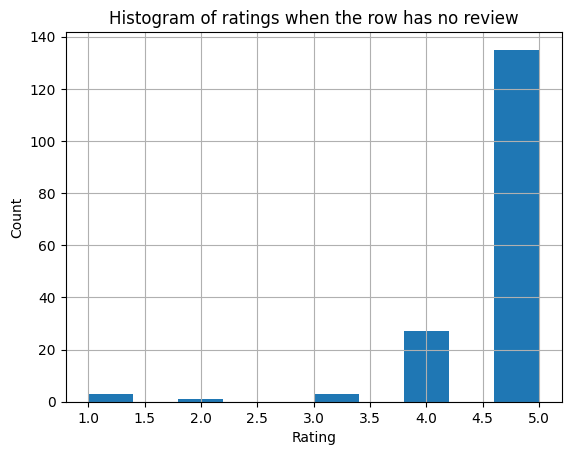

In [19]:
# Visualize a histogram of the ratings when the row has no review
no_review_df = sentiment_df[sentiment_df["review"].isna()]["rating"]
no_review_df.hist()
plt.title("Histogram of ratings when the row has no review")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

We can see that not having a review does not mean that the recipe is bad. It could be that the user did not review it. We will therefore only consider recipes with reviews.

In [20]:
# Keep only non NA reviews
sentiment_df = sentiment_df[sentiment_df["review"].notna()]

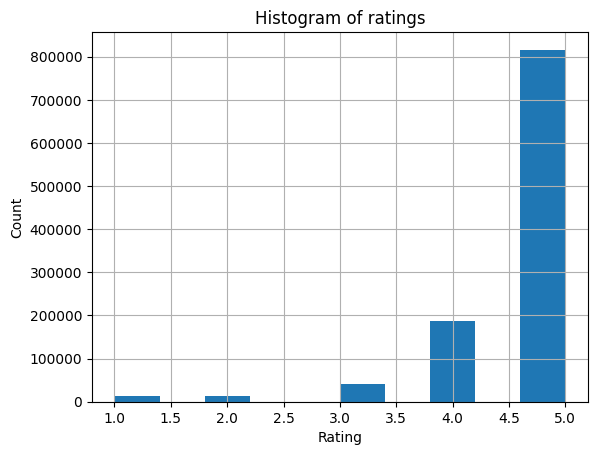

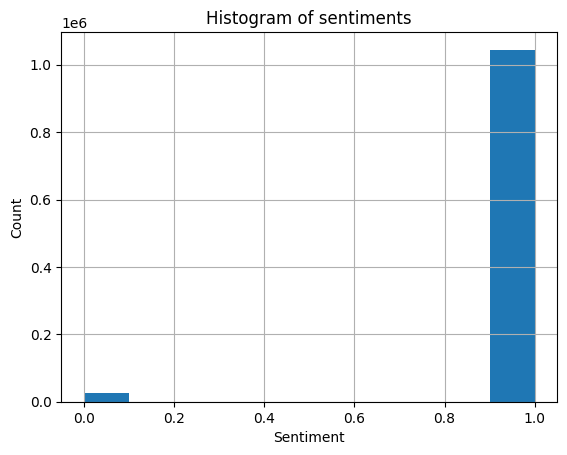

user_id  recipe_id  rating  \
0    38094      40893       4   
1  1293707      40893       5   
2     8937      44394       4   
3   126440      85009       5   
4    57222      85009       5   

                                              review  sentiment  
0  Great with a salad. Cooked on top of stove for...          1  
1  So simple, so delicious! Great for chilly fall...          1  
2  This worked very well and is EASY.  I used not...          1  
3  I made the Mexican topping and took it to bunk...          1  
4  Made the cheddar bacon topping, adding a sprin...          1

In [21]:
# Create a new column called sentiment with value 
# -> 1 if rating >= 3 (positif sentiment)
# -> 0 otherwise
sentiment_df["sentiment"] = sentiment_df["rating"].apply(lambda x: 1 if x >= 3 else 0)

# Visualize a histogram of the ratings
sentiment_df["rating"].hist()
plt.title("Histogram of ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Visualize a histogram of the sentiments
sentiment_df["sentiment"].hist()
plt.title("Histogram of sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Visualize the first 5 rows
sentiment_df.head(5)

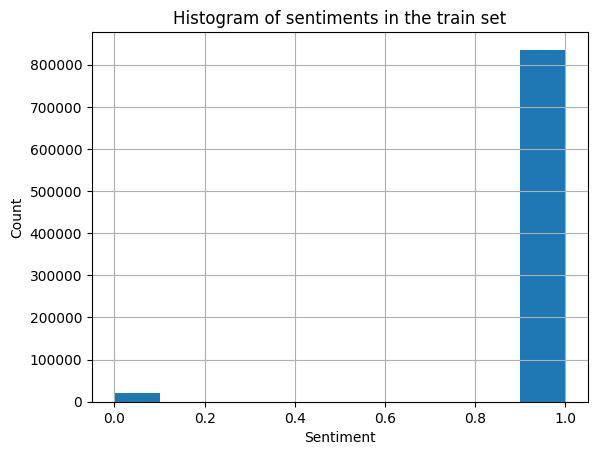

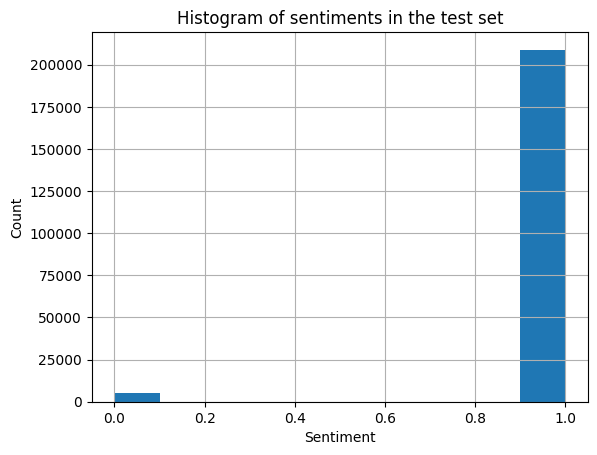

In [22]:
# Split the data into train and test sets
# use 80% of the data for training and 20% for testing
# stratify based on the value of sentiment
from sklearn.model_selection import train_test_split

train, val = train_test_split(sentiment_df, test_size = 0.2, stratify = sentiment_df["sentiment"], random_state = 42)

# Visualize a histogram of the sentiments in the train set
train["sentiment"].hist()
plt.title("Histogram of sentiments in the train set")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Visualize a histogram of the sentiments in the test set
val["sentiment"].hist()
plt.title("Histogram of sentiments in the test set")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [23]:
# Proportion of positive reviews
good_review_prop = sentiment_df[sentiment_df['sentiment'] == 1].shape[0] / sentiment_df.shape[0]
print(f"Proportion of positive reviews: {good_review_prop:.2f}")

Proportion of positive reviews: 0.97


As the classes are unbalanced, the model will tend to always predict 1 to minimise the classification error if we train it directly on this dataset. As the previous cell shows, such a model would at least reach 97% accuracy on the validation set. However, when we train a model this way, we observe on the gradio application that it's almost imposible to predict negative reviews, even with words such as bad, awful etc. <br>

To solve this problem, we train the model on a balanced dataset consisting of all negative reviews and a small proportion of the positive reviews. 

In [24]:
# Balanced dataset for training
positive_reviews = train[train['sentiment'] == 1]
negative_reviews = train[train['sentiment'] == 0]

positive_reviews = shuffle(positive_reviews).iloc[:50000,:]
balanced_reviews = shuffle(pd.concat([positive_reviews, negative_reviews]))

X_train, y_train = balanced_reviews['review'], balanced_reviews['sentiment']

In [24]:
# Classification pipeline
tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode', lowercase = True, ngram_range = (1,2) \
                                   ,stop_words = 'english', analyzer = 'word' \
                                  ,max_df = 0.8, max_features = 10000)
clf = SVC(probability = True)

text_clf = Pipeline([('tdidf', tfidf_vectorizer), ('classifieur', clf)])

In [28]:
# Check if the model has already been trained
model_path = "./sentiment_model.pkl"
if os.path.isfile(model_path):
    
    with open(model_path, 'rb') as file:
        text_clf = pickle.load(file)
        
# Otherwise, train the model
else:
    text_clf.fit(X_train, y_train)

In [ ]:
# Evaluate the model on training and validation sets
print(f"Model score on training data: {text_clf.score(X_train, y_train):.2f}")
print(f"Model score on test data: {text_clf.score(val.review, val.sentiment):.2f}")

In [34]:
# If there is no saved model, save the model in a pickle file
if not os.path.isfile(model_path):
    pickle.dump(text_clf, open("sentiment_model.pkl", "wb"))

In [29]:
# Instantiate the explainer object
class_names = ["negative", "positive"] # 0 -> negative, 1 -> positive
explainer = LimeTextExplainer(class_names=class_names)

Review: Fun recipe!  It's a different flavor than I'm used to for pesto, but I liked it a lot and I am also a big fan of using healthy greens instead of wasting them.  I used 6 cups chopped radish leaves, 6 garlic cloves and doubled the rest of the recipe.  I forgot to throw the nuts in, but it was still good.  Enjoyed this as a dip with some pita chips.  Thanks!  I'll use this recipe again the next time I have a bunch of radish leaves.

Class predicted: positive (p=0.9972478156396036) 
True class: positive

Explanation for class: positive
('used', 0.04634328323658906)
('Thanks', 0.04157222433112221)
('Enjoyed', 0.0390274856883848)
('good', 0.029928524630529113)
('liked', 0.025009485261416272)
('wasting', -0.024033345987736144)


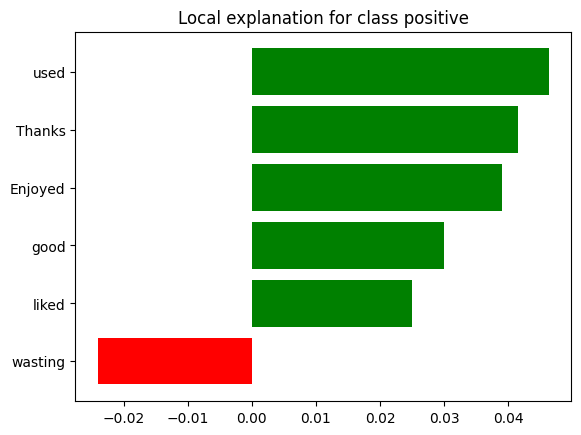

--------------------------------------------------

Review: Very good and traditional bierocks recipe!  To get an even more authentic taste add 1/2 tsp of caraway seeds, or more to taste, while cooking the cabbage down.

Class predicted: negative (p=0.558046624618041) 
True class: positive

Explanation for class: positive
('taste', -0.3756508434719065)
('good', 0.24268530936398217)
('seeds', 0.22027739000941773)
('traditional', -0.16708948192461082)
('tsp', 0.15205863388355628)
('authentic', -0.12100698608548471)


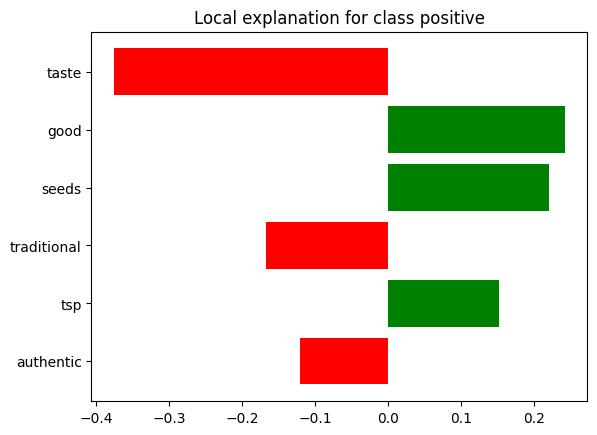

--------------------------------------------------

Review: The cupcakes turned out moist as promised, though it wasn't as sweet or chocolaty as I had expected it to be. I personally did not enjoy the outcome as it was too rubbery (yes, rubbery) and bland for my taste. The smell of the Miracle Whip was very strong and the taste of the flour was very evident (tasted as though it was still unbaked, although it was). Try it for yourself, perhaps you might like it? I would just say though that if you expect it to come out like a gooey chocolate rich light and fluffy cupcake {well, I was), it won't be that. If you like spongy cakes and you do not have a sweet tooth, perhaps this is the cake for you.

Class predicted: negative (p=0.9953318946029192) 
True class: negative

Explanation for class: positive
('bland', -0.0481887731945209)
('taste', -0.03373696459620757)
('rubbery', -0.031743184249193215)
('moist', 0.017571786763758427)
('wasn', -0.017302076865584274)
('like', -0.01695815056304923

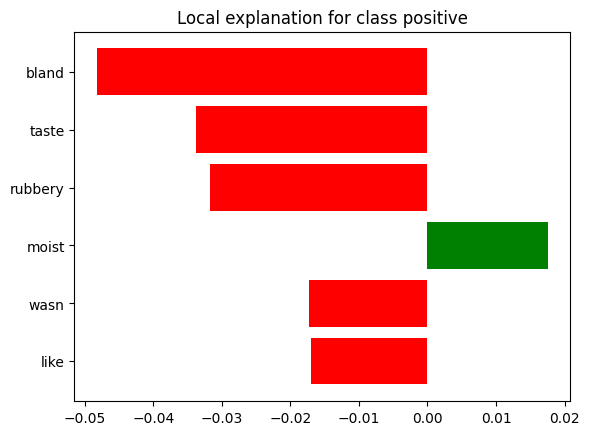

--------------------------------------------------



In [54]:
# pick 2 indices of positive review and 1 indice of negative review
indices = val.loc[val['sentiment'] == 1].index.to_list()
random.shuffle(indices)
indices = indices[:2]
negative_indice = val.loc[val['sentiment'] == 0].index.to_list()
random.shuffle(negative_indice)
negative_indice = negative_indice[0]
indices.append(negative_indice)

# loop through the indices and get the explanations
for index in indices:
    # get and print the review and corresponding label 
    review = val.review.loc[index]
    label = val.sentiment.loc[index]
    print(f"Review: {review}\n")

    # get the prediction, explication and the corresponding probability from the model
    exp = explainer.explain_instance(review, text_clf.predict_proba, num_features=6)
    prediction = text_clf.predict_proba([review])
    class_predicted = class_names[prediction.argmax(1)[0]]
    class_proba = prediction.max(1)[0]
    true_class = class_names[label]

    # print the prediction, explication and the corresponding probability
    print(f'Class predicted: {class_predicted} (p={class_proba}) ')
    print(f'True class: {class_names[label]}\n')
    print('Explanation for class: %s' % class_names[1])
    print('\n'.join(map(str, exp.as_list(label=1))))

    # visualize the most used words in the review and their corresponding weights
    exp.as_pyplot_figure(label=1)
    plt.show()

    # visualize the words in their context
    exp.show_in_notebook(text=True)
    plt.show()

    print('-'*50 + '\n')

# Part 3 : Neural Collaborative Filtering

In [55]:
from config import interactions_train_path, interactions_test_path, test_script_path

# Load training and testing interactions data
interactions_train = pd.read_csv(interactions_train_path)
interactions_test = pd.read_csv(interactions_test_path)
test_script_df = pd.read_csv(test_script_path)

Collaborative filtering suffers from recipes or users with few ratings.
We will only focus on the recipes with the most ratings and the users with the highest number of ratings.

In [56]:
# get number of unique recipes in the training data
unique_train_recipes = interactions_train.recipe_id.unique()
n_unique_recipes_train = len(unique_train_recipes)
print(f"Number of unique recipes in the training data: {n_unique_recipes_train}")

# get number of unique users in the training data
unique_train_users = interactions_train.user_id.unique()
n_unique_users_train = len(unique_train_users)
print(f"Number of unique users in the training data: {n_unique_users_train}")

# get number of unique recipes in the testing data
unique_test_recipes = interactions_test.recipe_id.unique()
n_unique_recipes_test = len(unique_test_recipes)
print(f"Number of unique recipes in the testing data: {n_unique_recipes_test}")

# get number of unique users in the testing data
unique_test_users = interactions_test.user_id.unique()
n_unique_users_test = len(unique_test_users)
print(f"Number of unique users in the testing data: {n_unique_users_test}")

# get number of unique users in the test_script data
unique_test_script_users = test_script_df.user_id.unique()
n_unique_users_test_script = len(unique_test_script_users)
print(f"Number of unique users in the test_script data: {n_unique_users_test_script}")

# get the number of nique recipes in the test_script data
unique_test_script_recipes = test_script_df.recipe_id.unique()
n_unique_recipes_test_script = len(unique_test_script_recipes)
print(f"Number of unique recipes in the test_script data: {n_unique_recipes_test_script}")

# get global list of unique recipes and users
unique_users = np.unique(np.concatenate((unique_train_users, unique_test_users, unique_test_script_users)))
unique_recipes = np.unique(np.concatenate((unique_train_recipes, unique_test_recipes, unique_test_script_recipes)))

# get total number of unique recipes and users
n_unique_users = len(unique_users)
n_unique_recipes = len(unique_recipes)
print(f"Total number of unique recipes: {n_unique_recipes}")
print(f"Total number of unique users: {n_unique_users}")

# create a dictionary that maps each user_id to a unique integer
user2id = dict((user_id, i) for (i, user_id) in enumerate(unique_users))

# create a dictionary that maps each recipe_id to a unique integer
recipe2id = dict((recipe_id, i) for (i, recipe_id) in enumerate(unique_recipes))

# save the dictionaries in a pickle file
pickle.dump(user2id, open("user2id.pkl", "wb"))
pickle.dump(recipe2id, open("recipe2id.pkl", "wb"))

Number of unique recipes in the training data: 160901
Number of unique users in the training data: 25076
Number of unique recipes in the testing data: 11695
Number of unique users in the testing data: 12455
Number of unique users in the test_script data: 10
Number of unique recipes in the test_script data: 10
Total number of unique recipes: 172606
Total number of unique users: 25076


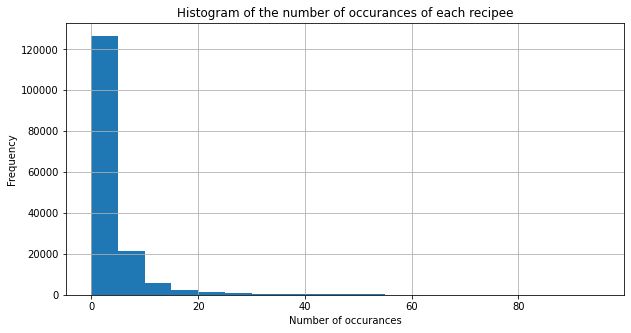

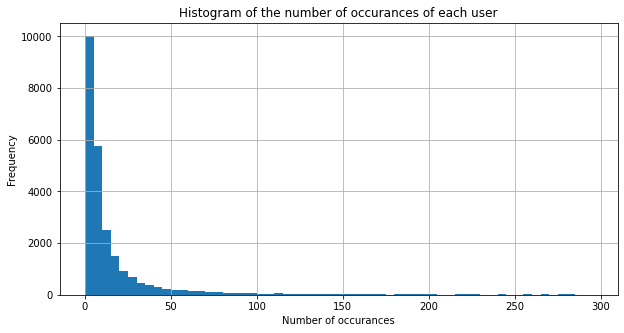

In [57]:
# visualize a histogram of the number of occurances of each recipee
interactions_train.recipe_id.value_counts().hist(bins=np.arange(0, 100, 5), figsize=(10, 5))
plt.title("Histogram of the number of occurances of each recipee")
plt.xlabel("Number of occurances")
plt.ylabel("Frequency")
plt.show()

# visualize a histogram of the number of occurances of each user
interactions_train.user_id.value_counts().hist(bins=np.arange(0, 300, 5), figsize=(10, 5))
plt.title("Histogram of the number of occurances of each user")
plt.xlabel("Number of occurances")
plt.ylabel("Frequency")
plt.show()

In [58]:
threshold = 10

# print number of recipes with more than 10 occurances
print(f"Number of recipes with more than {threshold} occurances: {(interactions_train.recipe_id.value_counts() > threshold).sum()}")

# print number of users with more than 10 occurances
print(f"Number of users with more than {threshold} occurances: {(interactions_train.user_id.value_counts() > threshold).sum()}")

Number of recipes with more than 10 occurances: 11120
Number of users with more than 10 occurances: 8640


* We can see that we have more than 10000 recipes with more than 10 occurences. We will therefore only consider these recipes.
* We can also see that we have more than 8000 users with more than 10 occurences. We will therefore only consider these users.

we choose 10 as a threshold because it helps us keep a reasonable number of recipes and users while keeping enough information on each recipe and user.

In [59]:
# get the ids of the recipes that appear less than 10 times in the training data
recipes_to_remove = interactions_train.recipe_id.value_counts()[interactions_train.recipe_id.value_counts() < threshold].index
print(f"We will remove {recipes_to_remove.shape[0]} recipes")

# get the ids of the users that appear less than 10 times in the training data
users_to_remove = interactions_train.user_id.value_counts()[interactions_train.user_id.value_counts() < threshold].index
print(f"We will remove {users_to_remove.shape[0]} users")

We will remove 148004 recipes
We will remove 15775 users


In [60]:
# Note : if the user_id or recipe_id is in the test dataset then we probably shouldn't remove it 
#      : from the training dataset
test_unique_users = interactions_test.user_id.unique()
test_unique_recipes = interactions_test.recipe_id.unique()
test_script_unique_users = test_script_df.user_id.unique()
test_script_unique_recipes = test_script_df.recipe_id.unique()

# delete the rows with the recipes that appear less than 10 times in the training data 
# and that are not in the test data or in the test script
less_than_10_occurences = interactions_train.recipe_id.isin(recipes_to_remove)
in_test_dataset = interactions_train.recipe_id.isin(test_unique_recipes)
in_test_script = interactions_train.recipe_id.isin(test_script_unique_recipes)
interactions_train = interactions_train[~less_than_10_occurences | in_test_dataset | in_test_script]

# delete the rows with the users that appear less than 10 times in the training data 
# and that are not in the test data or in the test script
less_than_10_occurences = interactions_train.user_id.isin(users_to_remove)
in_test_dataset = interactions_train.user_id.isin(test_unique_users)
in_test_script = interactions_train.user_id.isin(test_script_unique_users)
interactions_train = interactions_train[~less_than_10_occurences | in_test_dataset | in_test_script]


# get number of unique recipes in the training data
n_unique_recipes_train = interactions_train.recipe_id.nunique()
print(f"Number of unique recipes in the training data: {n_unique_recipes_train}")

# get number of unique users in the training data
n_unique_users_train = interactions_train.user_id.nunique()
print(f"Number of unique users in the training data: {n_unique_users_train}")

Number of unique recipes in the training data: 12897
Number of unique users in the training data: 15319


Good! We have a lot of recipes and users left.

In [61]:
# create pytorch dataset
class Ratings_Datset(Dataset):
    def __init__(self, df, user2id, recipe2id):
        self.df = df.reset_index()
        self.user2id = user2id
        self.recipe2id = recipe2id

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = self.user2id[self.df['user_id'][idx]]
        user = torch.tensor(user, dtype=torch.long)
        recipe = self.recipe2id[self.df['recipe_id'][idx]]
        recipe = torch.tensor(recipe, dtype=torch.long)
        rating = torch.tensor(self.df['rating'][idx], dtype=torch.float)
        return user, recipe, rating

# create pytorch datasets & dataloaders
train_dataset = Ratings_Datset(interactions_train, user2id, recipe2id)
test_dataset = Ratings_Datset(interactions_test, user2id, recipe2id)
trainloader = DataLoader(train_dataset, batch_size=512, shuffle=True ,num_workers=6)
testloader = DataLoader(test_dataset, batch_size=64, num_workers=6)

### NCF without Matrix Factorization Vectors

In [62]:
# Create NCF model
class NCF(nn.Module):
    def __init__(self, n_users, n_recipes, n_factors=8):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors)
        self.recipe_embeddings = torch.nn.Embedding(n_recipes, n_factors)
        self.predictor = torch.nn.Sequential(
            nn.Linear(in_features=n_factors*2, out_features=64),
            nn.Linear(in_features=64, out_features=32),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, user, recipe):
        user_embedding = self.user_embeddings(user)
        recipe_embedding = self.recipe_embeddings(recipe)

        # Concatenate the two embedding layers
        z = torch.cat([user_embedding, recipe_embedding], dim=-1)
        return self.predictor(z)
    
def train(model, optimizer, trainloader, epochs=30):
    criterion = nn.MSELoss(reduction='mean')
    t = tqdm(range(epochs))
    for epoch in t:
        corrects = 0
        total = 0
        train_loss = []
        for users, recipes, ratings in trainloader:
            users = users.cpu()
            recipes = recipes.cpu()
            ratings = ratings.cpu() / 5
            y_hat = model(users, recipes)
            loss = criterion(y_hat, ratings.unsqueeze(1).float())
            train_loss.append(loss.item())
            total += ratings.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f"loss: {mean(train_loss)}")

def test(model, testloader, m_eval=False):
    running_mae = 0
    with torch.no_grad():
        corrects = 0
        total = 0
        for users, recipes, ratings in testloader:
            users = users.cpu()
            recipes = recipes.cpu()
            y = ratings.cpu() / 5
            y_hat = model(users, recipes).flatten()
            error = torch.abs(y_hat - y).sum().data

            running_mae += error
            total += y.size(0)

    mae = running_mae/total
    return mae * 5

In [ ]:
# save n_unique_users and n_unique_recipes in n_users_recipes.json
import json
with open('n_users_recipes.json', 'w') as f:
    json.dump({'n_users': int(n_unique_users), 'n_recipes': int(n_unique_recipes)}, f)

In [64]:
model = NCF(n_unique_users, n_unique_recipes).cpu()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=1)

loss = test(model, testloader)
print(f"Loss MAE: {loss:.2f}")

# save model weights
torch.save(model.state_dict(), 'weights.pth')

  0%|          | 0/1 [00:00<?, ?it/s]

Loss MAE: 0.87


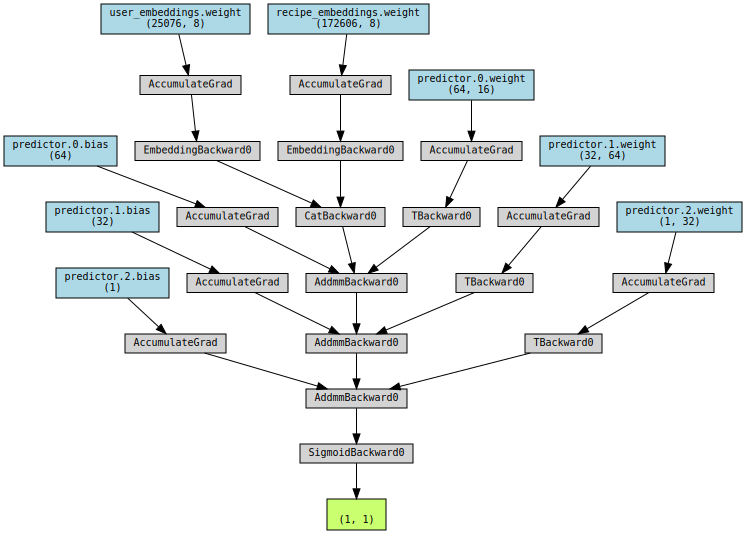

In [76]:
# visulize the model
from torchviz import make_dot
x = torch.tensor([1])
y = torch.tensor([1])
make_dot(model(x, y), params=dict(model.named_parameters()))

## NCF with Matrix Factorization Vectors

In [ ]:
import torch.optim as optim

class NeuMF(nn.Module):
    def __init__(self, num_users, num_recipes, embedding_dim, hidden_dim):
        super(NeuMF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.recipe_embedding = nn.Embedding(num_recipes, embedding_dim)
        
        self.mlp_user_embedding = nn.Embedding(num_users, embedding_dim)
        self.mlp_recipe_embedding = nn.Embedding(num_recipes, embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        self.output_layer = nn.Linear(embedding_dim + hidden_dim, 1)
    
    def forward(self, user, recipe):
        mf_user_embedding = self.user_embedding(user)
        mf_recipe_embedding = self.recipe_embedding(recipe)
        mf_output = mf_user_embedding * mf_recipe_embedding
        
        mlp_user_embedding = self.mlp_user_embedding(user)
        mlp_recipe_embedding = self.mlp_recipe_embedding(recipe)
        mlp_input = torch.cat((mlp_user_embedding, mlp_recipe_embedding), dim=1)
        mlp_output = self.mlp(mlp_input)
        
        fusion_output = torch.cat((mf_output, mlp_output), dim=1)
        output = self.output_layer(fusion_output)
        
        return output.squeeze()

In [66]:
# Hyperparameters
num_users = len(user2id)
num_recipes = len(recipe2id)
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.001
num_epochs = 4

# save n_unique_users and n_unique_recipes in n_users_recipes.json
import json
with open('n_users_recipes.json', 'w') as f:
    json.dump({'n_users': int(n_unique_users), 'n_recipes': int(n_unique_recipes)}, f)

# Create NeuMF model
model = NeuMF(num_users, num_recipes, embedding_dim, hidden_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for user, recipe, rating in trainloader:
        optimizer.zero_grad()
        
        # Forward pass
        output = model(user, recipe)
        
        # Calculate loss
        loss = criterion(output, rating)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(trainloader)}")

Epoch 1/4 - Loss: 1.9372171970849823
Epoch 2/4 - Loss: 0.8532237539473865
Epoch 3/4 - Loss: 0.7905581787402142
Epoch 4/4 - Loss: 0.7510056487236563


In [68]:
def test(model, testloader, m_eval=False):
    running_mae = 0
    with torch.no_grad():
        corrects = 0
        total = 0
        for users, recipes, ratings in testloader:
            users = users.cpu()
            recipes = recipes.cpu()
            y = ratings.cpu()
            y_hat = model(users, recipes).flatten()
            error = torch.abs(y_hat - y).sum().data

            running_mae += error
            total += y.size(0)

    mae = running_mae/total
    return mae

# Evaluation loop
loss = test(model, testloader)
print(f"Loss MAE: {loss:.2f}")

# save model weights
torch.save(model.state_dict(), 'weights.pth')

Loss MAE: 0.88


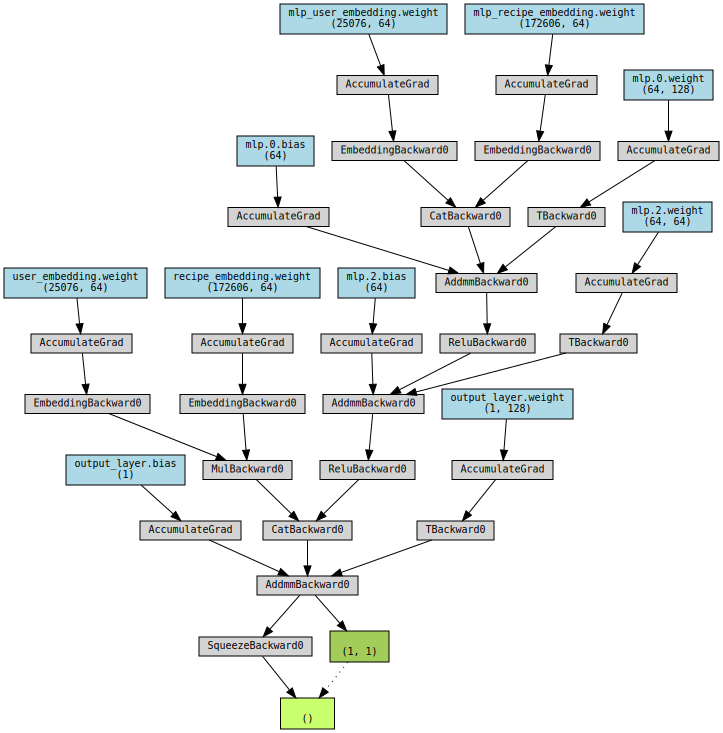

In [78]:
# visulize the model
from torchviz import make_dot
x = torch.tensor([1])
y = torch.tensor([1])
make_dot(model(x, y), params=dict(model.named_parameters()))